
# Titanic — 1‑Hour Data Task (Clean → EDA → Viz → ML)

**Goal:** Clean the dataset, do quick EDA, make simple visualizations, and build a basic ML model (Logistic Regression).  
**Bonus:** Optional Decision Tree as an extra model.

> **How to run**  
> 1) Put `titanic.csv` in the same folder as this notebook (download from Kaggle).  
> 2) Run all cells from top to bottom.  
> 3) All plots will be saved to the `figures/` folder automatically.



## 1) Imports & Helper Function
- Import required libraries.  
- Prepare a helper to load Titanic data: first from `titanic.csv`, or from seaborn if available (requires internet).


In [33]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, accuracy_score)

# Create figures directory
FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True)

#Loading Dataset
df_raw = sns.load_dataset("titanic")

print("Loaded shape:", df_raw.shape)
df_raw.head()

Loaded shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True



## 2) Quick Data Peek
- Display dataset shape, columns, datatypes, and basic statistics.  
- Helps us understand what features we can use.


In [34]:

print("\nColumns:", list(df_raw.columns))
print("\nInfo:")
print(df_raw.info())
display(df_raw.describe(include='all').T.head(12))



Columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
d

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,891,3,Third,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
who,891,3,man,537,NaN,NaN,NaN,NaN,NaN,NaN,NaN



## 3) Select Minimal Features
We use the following columns for this quick task:  
- `survived` → renamed to `target`  
- `pclass, sex, age, sibsp, parch, fare, embarked`


In [35]:
# Selecting Important Features
df = df_raw[["survived", "pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]].copy()
df.rename(columns={"survived": "target"}, inplace=True)

# Counting The Null Values
print(df.isna().sum())
df.head()


target        0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64


,target,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S



## 4) Handle Missing Values
- Fill `age` with the **median**.  
- Fill `embarked` with the most frequent value (**mode**).


In [36]:

df["age"] = df["age"].fillna(df["age"].median())

df.dropna(subset=["embarked"], inplace=True)

print("Missing values after cleaning:\n", df.isna().sum())
df.head(3)


Missing values after cleaning:
 target      0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


,target,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S



## 5) Simple Exploratory Data Analysis (EDA)
- Survival rates by **gender**, **class**, and **age group**.  
- Quick bar charts for insights.


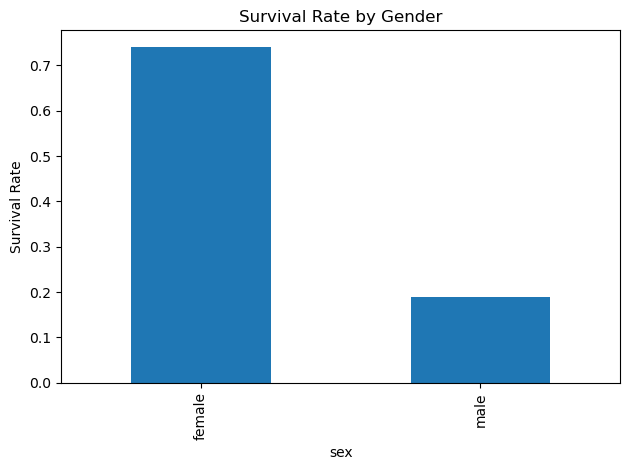

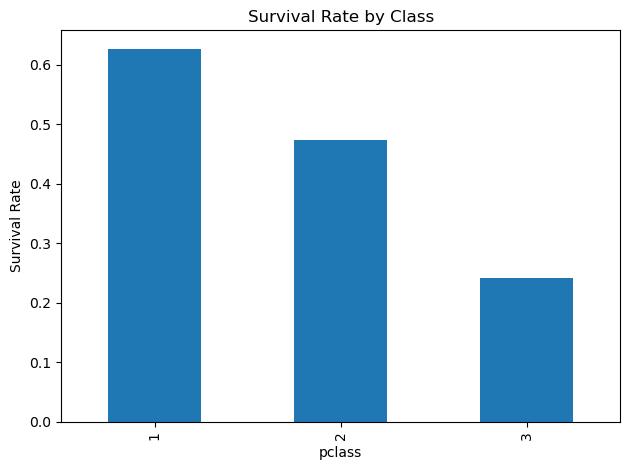

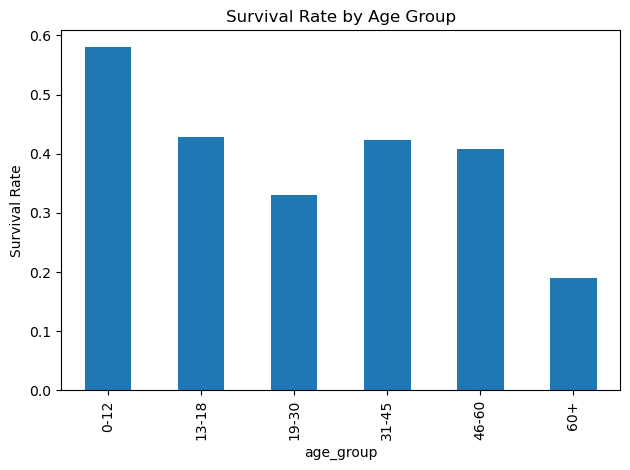

In [37]:

# Define age groups
age_bins = [0, 12, 18, 30, 45, 60, 120]
age_labels = ["0-12", "13-18", "19-30", "31-45", "46-60", "60+"]
df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, include_lowest=True)

# Reusable plotting function
def plot_survival_rate(group_col, title, filename):
    ax = (
        df.groupby(group_col, observed=False)["target"]
        .mean()
        .plot(kind="bar", title=title)
    )
    ax.set_ylabel("Survival Rate")
    plt.tight_layout()
    plt.savefig(FIG_DIR / filename, dpi=140)
    plt.show()

# Plots
plot_survival_rate("sex", "Survival Rate by Gender", "survival_by_gender.png")
plot_survival_rate("pclass", "Survival Rate by Class", "survival_by_class.png")
plot_survival_rate("age_group", "Survival Rate by Age Group", "survival_by_age.png")




## 6) Encode Categorical Variables
Convert `sex` and `embarked` into numeric dummy variables using one-hot encoding.


In [38]:

df = pd.get_dummies(df, columns=["sex","embarked"], drop_first=True)
df.head()


,target,pclass,age,sibsp,parch,fare,age_group,sex_male,embarked_Q,embarked_S
0,0,3,22.0,1,0,7.2500,19-30,True,False,True
1,1,1,38.0,1,0,71.2833,31-45,False,False,False
2,1,3,26.0,0,0,7.9250,19-30,False,False,True
3,1,1,35.0,1,0,53.1000,31-45,False,False,True
4,0,3,35.0,0,0,8.0500,31-45,True,False,True



## 7) Train/Test Split
Split the data into training (70%) and test (30%) sets using `random_state=42` for reproducibility.


In [39]:

X = df.drop(columns=["target","age_group"], errors="ignore")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((622, 8), (267, 8))


## 8) Logistic Regression Model
A simple baseline ML model for classification.


In [40]:

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", (round(acc, 3)*100),'%')
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 79.4 %

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83       165
           1       0.74      0.72      0.73       102

    accuracy                           0.79       267
   macro avg       0.78      0.78      0.78       267
weighted avg       0.79      0.79      0.79       267




## 9) Confusion Matrix
Shows how many predictions were correct vs incorrect in each class.


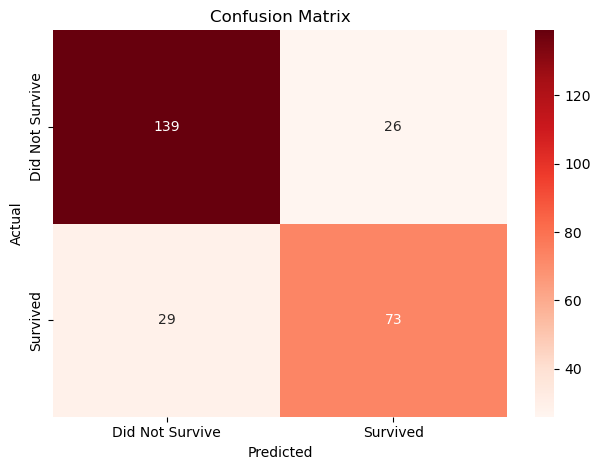

In [41]:

cm = confusion_matrix(y_test, y_pred)
fig = plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Did Not Survive", "Survived"],
            yticklabels=["Did Not Survive", "Survived"])

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(FIG_DIR / "confusion_matrix.png", dpi=140)
plt.show()



## 10) ROC Curve and AUC
Visualizes model performance at different thresholds.  
Higher AUC = better classification ability.


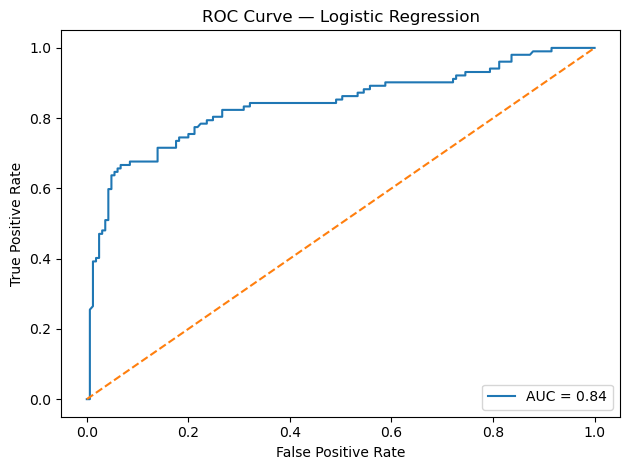

In [42]:

fpr, tpr, thr = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curve_logreg.png", dpi=140)
plt.show()



## 11) Bonus: Decision Tree Classifier
A simple non-linear model for comparison.


Decision Tree Accuracy: 79.0 %

Classification Report (Tree):
               precision    recall  f1-score   support

           0       0.77      0.94      0.85       165
           1       0.85      0.55      0.67       102

    accuracy                           0.79       267
   macro avg       0.81      0.74      0.76       267
weighted avg       0.80      0.79      0.78       267



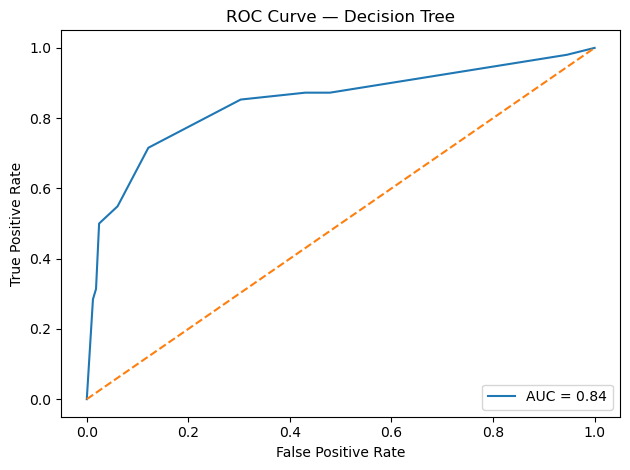

In [43]:

tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)[:,1]

acc_tree = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Accuracy:", (round(acc_tree, 3))*100,'%')
print("\nClassification Report (Tree):\n", classification_report(y_test, y_pred_tree))

fpr_t, tpr_t, _ = roc_curve(y_test, y_prob_tree)
auc_t = roc_auc_score(y_test, y_prob_tree)

plt.figure()
plt.plot(fpr_t, tpr_t, label=f"AUC = {auc_t:.2f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Decision Tree")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curve_tree.png", dpi=140)
plt.show()



## 12) Quick Summary (for Upwork)
- Data cleaned (handled missing values).  
- EDA performed with simple bar charts.  
- Built a Logistic Regression model (~baseline).  
- Evaluated with Accuracy, Confusion Matrix, ROC/AUC.  
- Bonus: Compared with a Decision Tree model.
